In [16]:
# Parameters
CONTEXTLENGTH = 12840  # will be overridden by papermill

This notebook loads moirai2 model and makes predictions using it. Data is loaded from data/interim and stored to data/processed/prediction_matrices
source /home/valtti/code/ed-ml-multivar/uni2ts/venv/bin/activate

In [17]:
#import torch
#import matplotlib
#matplotlib.use('Agg')  # Use non-interactive backend
import matplotlib.pyplot as plt
import pandas as pd
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split
from gluonts.dataset.util import to_pandas
from huggingface_hub import hf_hub_download
import numpy as np
import logging
from pyprojroot import here

import sys
sys.path.append(str(here() / 'scripts'))
sys.path.append(str(here() / 'uni2ts'))

from utils import (get_data, save)
#from uni2ts.eval_util.plot import plot_single
from uni2ts.model.moirai import MoiraiForecast, MoiraiModule
from uni2ts.model.moirai_moe import MoiraiMoEForecast, MoiraiMoEModule
from uni2ts.model.moirai2 import Moirai2Forecast, Moirai2Module

In [18]:
MAXMODELCONTEXT= 12840 # max context length for this model (no context length limit for this model)
MAXCONTEXT = 12840 # max context length for this dataset (2017-01-01 - 2018-06-19)
if CONTEXTLENGTH > MAXMODELCONTEXT:
    CONTEXTLENGTH = MAXMODELCONTEXT

if CONTEXTLENGTH > MAXCONTEXT:
    CONTEXTLENGTH = MAXCONTEXT

MODEL = 'moirai2'
TARGET = 'occ'
FEATURESET = 'u'
TESTNAME = f'{TARGET}-{MODEL}-{FEATURESET}-{CONTEXTLENGTH}'
TESTSTART = pd.Timestamp('20180620')
TESTSIZE = 365*24

In [19]:
logging.basicConfig(
        format='%(asctime)s - %(message)s', 
        level=logging.INFO,
        filename=here() / f"logs/logger/{TESTNAME}.log",      
        filemode='w'
        )
logging.info('Starting test.')
logging.info(f'MODEL: {MODEL} TARGET: {TARGET} FEATURESET:'
     f'{FEATURESET} CONTEXTLENGTH: {CONTEXTLENGTH}')

In [20]:
data = get_data(TARGET, MODEL)
#y_context = get_y_context(data, TARGET, CONTEXTLENGTH, TESTSTART)
#pc, fc = get_x(data, FEATURESET)


In [21]:
cd = {
        'occ' : 'Target:Occupancy',
        'arr' : 'Target:Arrivals'
    }
target_name = cd[TARGET]
y = data[target_name]

y = PandasDataset(y, target='target')

_, test_template = split(y, offset=-TESTSIZE)
y_test = test_template.generate_instances(
    prediction_length=24,
    windows=TESTSIZE // 24,
    distance=24
)

In [22]:
test_template.dataset

PandasDataset<size=1, freq=H, num_feat_dynamic_real=0, num_past_feat_dynamic_real=0, num_feat_static_real=0, num_feat_static_cat=0, static_cardinalities=[]>

In [23]:
y = test_template.dataset
entry = next(iter(y))  # y is PandasDataset(...)
print(entry.keys())
print("start:", entry["start"], "len(target):", len(entry["target"]))

s = to_pandas(entry)  # pandas Series with DateTimeIndex
print("index range:", s.index.min(), "→", s.index.max(), "| freq:", s.index.freqstr)
display(s.tail(48))  # last 2 days for a quick sanity check

dict_keys(['start', 'target'])
start: 2017-01-01 00:00 len(target): 21600
index range: 2017-01-01 00:00 → 2019-06-19 23:00 | freq: H


2019-06-18 00:00    21.0
2019-06-18 01:00    16.0
2019-06-18 02:00    18.0
2019-06-18 03:00    13.0
2019-06-18 04:00     9.0
2019-06-18 05:00     5.0
2019-06-18 06:00     8.0
2019-06-18 07:00     8.0
2019-06-18 08:00    16.0
2019-06-18 09:00    24.0
2019-06-18 10:00    31.0
2019-06-18 11:00    44.0
2019-06-18 12:00    53.0
2019-06-18 13:00    58.0
2019-06-18 14:00    67.0
2019-06-18 15:00    74.0
2019-06-18 16:00    71.0
2019-06-18 17:00    73.0
2019-06-18 18:00    63.0
2019-06-18 19:00    56.0
2019-06-18 20:00    52.0
2019-06-18 21:00    46.0
2019-06-18 22:00    42.0
2019-06-18 23:00    40.0
2019-06-19 00:00    34.0
2019-06-19 01:00    24.0
2019-06-19 02:00    19.0
2019-06-19 03:00    11.0
2019-06-19 04:00     6.0
2019-06-19 05:00     7.0
2019-06-19 06:00     8.0
2019-06-19 07:00    10.0
2019-06-19 08:00    19.0
2019-06-19 09:00    23.0
2019-06-19 10:00    29.0
2019-06-19 11:00    39.0
2019-06-19 12:00    45.0
2019-06-19 13:00    56.0
2019-06-19 14:00    62.0
2019-06-19 15:00    61.0


In [24]:
if MODEL == "moirai":
    model = MoiraiForecast(
        module=MoiraiModule.from_pretrained(f"Salesforce/moirai-1.1-R-small"),
        prediction_length=24,
        context_length=CONTEXTLENGTH,
        patch_size="auto",
        num_samples=100,
        target_dim=1,
        feat_dynamic_real_dim=0,
        past_feat_dynamic_real_dim=0,
    )
elif MODEL == "moirai-moe":
    model = MoiraiMoEForecast(
        module=MoiraiMoEModule.from_pretrained(f"Salesforce/moirai-moe-1.0-R-small"),
        prediction_length=24,
        context_length=CONTEXTLENGTH,
        patch_size="auto", 
        num_samples=100,
        target_dim=1,
        feat_dynamic_real_dim=0,
        past_feat_dynamic_real_dim=0,
    )
elif MODEL == "moirai2":
    model = Moirai2Forecast(
        module=Moirai2Module.from_pretrained(
            f"Salesforce/moirai-2.0-R-small",
            ),
        prediction_length=24,
        context_length=CONTEXTLENGTH,
        target_dim=1,
        feat_dynamic_real_dim=0,
        past_feat_dynamic_real_dim=0,
    )


In [25]:
predictor = model.create_predictor(batch_size=32)
forecasts = predictor.predict(y_test.input)

input_it = iter(y_test.input)
label_it = iter(y_test.label)
forecast_it = iter(forecasts)

inp = next(input_it)
label = next(label_it)
forecast = next(forecast_it)

In [26]:
# Convert forecasts (which may be a generator or iterable of forecast objects) into a pandas DataFrame
import pandas as pd

# If forecasts is a generator or iterable, convert to list
forecast_list = list(forecasts)

# For each forecast, extract the mean prediction (if available), else use samples or quantiles
def forecast_to_series(forecast):
    if hasattr(forecast, "mean"):
        return pd.Series(forecast.mean)
    elif hasattr(forecast, "samples"):
        return pd.Series(forecast.samples.mean(axis=0))
    elif hasattr(forecast, "quantiles"):
        # Use median if available
        if "0.5" in forecast.quantiles:
            return pd.Series(forecast.quantile("0.5"))
        else:
            # Use first quantile as fallback
            return pd.Series(forecast.quantile(forecast.quantiles[0]))
    else:
        # Fallback: try to convert to numpy array
        return pd.Series(np.asarray(forecast))

# Combine all forecasts into a DataFrame (each row is a forecast for one time series)
pd_forecast = pd.DataFrame([forecast_to_series(f) for f in forecast_list])

In [27]:
# save pd_forecast to csv file
save(model_name=MODEL, featureset_name=FEATURESET, target_name=TARGET,
     context_length=CONTEXTLENGTH, test_start=TESTSTART, y_pred=pd_forecast)

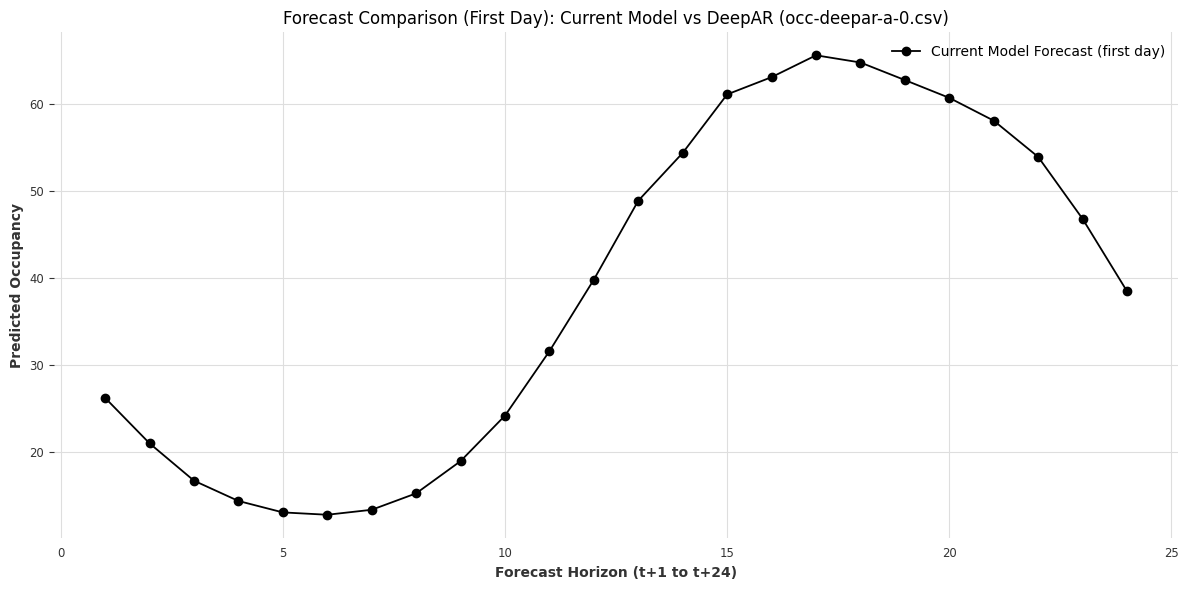

In [28]:
import matplotlib.pyplot as plt
import pandas as pd
import os
i =9

# Plot the first day's forecast for the current model
if isinstance(pd_forecast, pd.DataFrame):
    # Take the first row (first day)
    forecast_first_day = pd_forecast.iloc[i]
else:
    forecast_first_day = pd.Series(pd_forecast)

plt.figure(figsize=(12, 6))
plt.plot(
    range(1, len(forecast_first_day) + 1),
    forecast_first_day.values,
    label="Current Model Forecast (first day)",
    marker='o'
)

# Load occ-deepar-a-0.csv from the processed prediction_matrices folder, handle missing file gracefully
csv_path = "/home/valtti/code/ed-ml-multivar/data/processed/prediction_matrices/50/occ-deepar-a-0.csv"
if os.path.exists(csv_path):
    df_csv = pd.read_csv(csv_path)
    # The CSV has columns: datetime, t+1, t+2, ..., t+24
    # We'll plot the first day's forecast (first row after datetime)
    csv_first_day = df_csv.iloc[i, 1:]  # skip datetime column, take first row
    plt.plot(
        range(1, len(csv_first_day) + 1),
        csv_first_day.values,
        label="DeepAR Model (occ-deepar-a-0.csv first day)",
        marker='x'
    )
else:
    print(f"Warning: File not found: {csv_path}. Skipping DeepAR CSV comparison plot.")

plt.xlabel("Forecast Horizon (t+1 to t+24)")
plt.ylabel("Predicted Occupancy")
plt.title("Forecast Comparison (First Day): Current Model vs DeepAR (occ-deepar-a-0.csv)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("forecast_comparison_first_day.pdf")

In [29]:
import pandas as pd

# Check if forecast has a .mean or .samples attribute (common in GluonTS)
if hasattr(forecast, "mean"):
    preddata = pd.DataFrame({"mean": forecast.mean})
elif hasattr(forecast, "samples"):
    # Use the mean of samples as prediction
    preddata = pd.DataFrame({"mean": forecast.samples.mean(axis=0)})
elif hasattr(forecast, "quantiles"):
    # If quantiles are available, use them
    preddata = pd.DataFrame({q: forecast.quantile(q) for q in forecast.quantiles})
else:
    # Fallback: try to convert to numpy and wrap in DataFrame
    preddata = pd.DataFrame(np.asarray(forecast))

# Now you can inspect the DataFrame
preddata.head()
preddata.tail()
preddata.shape
preddata.index
preddata.columns


Index(['mean'], dtype='object')

In [30]:
preddata

,mean
0,30.353306
1,24.527458
2,19.767891
3,16.306906
4,14.883677
5,13.976576
6,14.676401
7,16.983009
8,21.498522
9,27.351166
